In [1]:
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model
import tensorflow_model_optimization as tfmot

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.qlayers import QDense, QActivation
from qkeras import QConv1D
from qkeras.utils import load_qmodel

import hist
from hist import Hist

import random
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.pyplot import cm
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

import hls4ml
import hls4ml.utils
import hls4ml.converters



2023-11-27 15:30:22.254119: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 15:30:22.608369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/ofoo/tau_nn_conversion/hls4ml/hls4ml/converters/__init__.py:25: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [2]:
os.environ['PATH'] += os.pathsep + '/tools/Xilinx/Vitis_HLS/2022.1/bin'

model = load_qmodel("../models/quantized_merged_pruned_gamma30.h5")


config = hls4ml.utils.config_from_keras_model(model, granularity='name')

for Layer in config['LayerName'].keys():
        if "Dense" in Layer:

            config['LayerName'][Layer]['Strategy'] = 'Latency'
            config['LayerName'][Layer]['ReuseFactor'] = 1

        else:
            config['LayerName'][Layer]['Strategy'] = 'Latency'
            config['LayerName'][Layer]['ReuseFactor'] = 1

hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       backend='Vitis',
                                                       project_name='tau_nn', #I'm not very creative
                                                       clock_period=2.8, #1/360MHz = 2.8ns
                                                       hls_config=config,
                                                       output_dir='hardwareII_COM/testing60_pruned/hls4ml_prj',
                                                       part='xcvu9p-flga2104-2L-e')


# hls_model = hls4ml.converters.convert_from_keras_model(
#     model, hls_config=config, output_dir='model_3/hls4ml_prj', part='xcu250-figd2104-2L-e'
# )
hls_model.compile()

#hls_model.build(csim=False)
#hls4ml.converters.convert_from_keras_model


Interpreting Model
Topology:
Layer name: model_input, layer type: InputLayer, input shapes: [[None, 80]], output shape: [None, 80]
Layer name: Dense_1, layer type: QDense, input shapes: [[None, 80]], output shape: [None, 25]
Layer name: relu_1, layer type: Activation, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: Dense_2, layer type: QDense, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: relu_2, layer type: Activation, input shapes: [[None, 25]], output shape: [None, 25]
Layer name: Dense_3, layer type: QDense, input shapes: [[None, 25]], output shape: [None, 15]
Layer name: relu_3, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: Dense_4, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: relu_4, layer type: Activation, input shapes: [[None, 15]], output shape: [None, 15]
Layer name: Dense_5, layer type: QDense, input shapes: [[None, 15]], output shape: [None, 10]
Layer name:

Done


In [17]:
num_samples = 10000

# Create a tensor of shape [10000, 80] with random values between 0 and 10
random_tensors = tf.random.uniform(shape=[num_samples, 80], minval=1, maxval=10, dtype=tf.float32).numpy()
print(random_tensors)
print(random_tensors.shape)
print(type(random_tensors))
y_qkeras = model.predict(np.ascontiguousarray(random_tensors))[0].flatten()
y_hls = hls_model.predict(np.ascontiguousarray(random_tensors))[0].flatten()
y_qkeras

[[5.100168  6.980795  3.8843498 ... 9.194688  5.4877424 2.1096096]
 [6.2099075 1.2420458 1.0907938 ... 5.4855514 6.641739  4.1629105]
 [1.0463926 6.228948  5.456087  ... 1.1075952 8.04313   2.5161755]
 ...
 [2.3083353 8.768353  4.283992  ... 3.3890135 4.3052077 6.981757 ]
 [6.0344214 2.7178574 8.246341  ... 7.164464  2.4233313 4.887241 ]
 [7.0080624 2.9895158 8.967423  ... 3.1418233 1.604983  8.649497 ]]
(10000, 80)
<class 'numpy.ndarray'>
313/313 [==============================] - 0s 922us/step


array([0.03700378, 0.02907966, 0.03700378, ..., 0.02907966, 0.02938994,
       0.04220153], dtype=float32)

In [18]:
y_hls

array([0.03613281, 0.02929688, 0.03613281, ..., 0.03808594, 0.02929688,
       0.05761719], dtype=float32)

In [19]:
print(np.max(abs(np.array(y_qkeras) - np.array(y_hls))))
print(np.min(abs(np.array(y_qkeras) - np.array(y_hls))))
y=abs(np.array(y_qkeras) - np.array(y_hls))

0.789129
3.023073e-06


(array([5.438e+03, 2.781e+03, 1.300e+02, 7.900e+01, 6.300e+01, 6.400e+01,
        1.030e+02, 1.980e+02, 1.130e+02, 3.100e+01, 5.900e+01, 1.230e+02,
        2.500e+01, 3.500e+01, 1.440e+02, 4.300e+01, 5.200e+01, 1.300e+01,
        4.400e+01, 8.000e+00, 1.200e+01, 2.500e+01, 7.000e+00, 1.200e+01,
        1.400e+01, 1.300e+01, 1.100e+01, 1.100e+01, 4.000e+00, 7.000e+00,
        5.000e+00, 6.000e+00, 5.000e+00, 9.000e+00, 1.300e+01, 1.000e+00,
        3.000e+00, 1.300e+01, 3.900e+01, 3.000e+00, 4.000e+00, 4.000e+00,
        1.000e+00, 2.000e+00, 8.000e+00, 1.100e+01, 4.000e+00, 1.000e+00,
        4.000e+00, 5.000e+00, 0.000e+00, 2.000e+00, 7.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 5.000e+00, 4.000e+00, 0.000e+00,
        4.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 7.000e+00, 5.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        4.000e+00, 4.000e+00, 1.000e+0

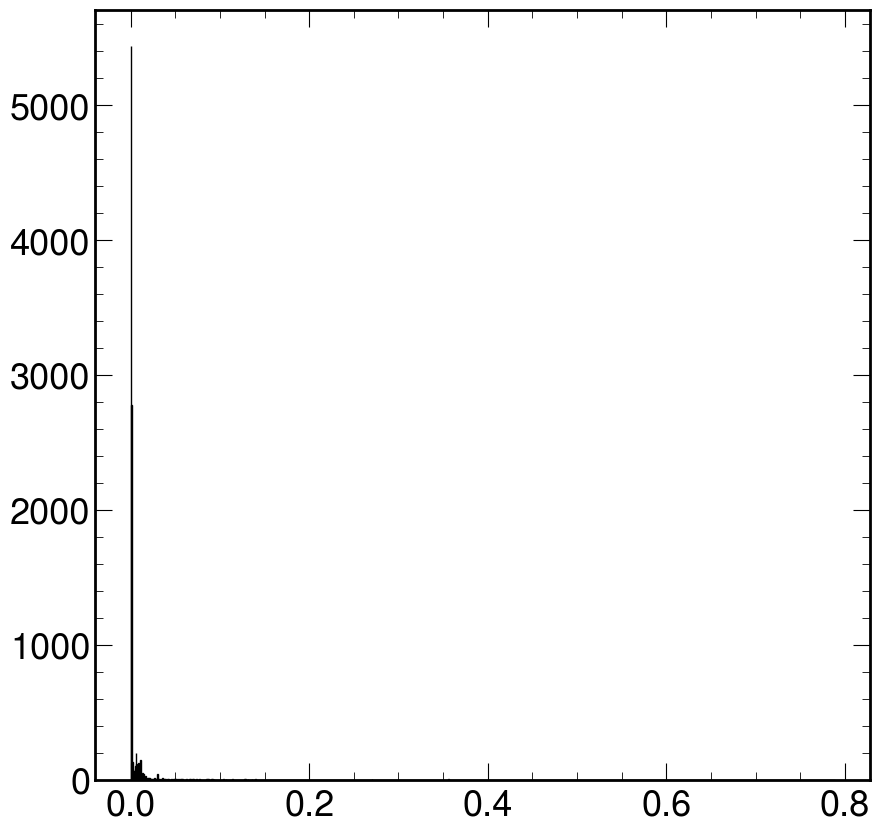

In [21]:
# Create x-coordinates for each bar
x1 = np.arange(len(y_qkeras))
x2 = np.arange(len(y_hls))

#plt.bar(y, x1, color = "black")
plt.hist(y, bins=1000, edgecolor='black')
#plt.xlim(0, 0.05)